In [16]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from itertools import combinations
from collections import defaultdict

In [17]:
df = pd.read_csv("Downloads/california_outages_with_fire_features.csv")

In [18]:
numeric_cols = ['fires_7day', 'fires_30day', 'acres_7day', 'acres_30day', 'max_frp']
df[numeric_cols] = df[numeric_cols].fillna(0)

binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df_binned = pd.DataFrame(binner.fit_transform(df[numeric_cols]), columns=[f"{col}_bin" for col in numeric_cols])
df[df_binned.columns] = df_binned.astype(int)

In [19]:
selected_cols = [
    'season', 'is_weekend', 'CAUSE.CATEGORY', 'is_high_severity',
    'is_long_duration', 'has_active_fire', 'is_high_fire_activity'
] + list(df_binned.columns)

df_encoded = pd.get_dummies(df[selected_cols], prefix_sep='=')

In [20]:
min_support = 0.3
min_conf = 0.7
min_support_count = int(min_support * len(df_encoded))

item_counts = defaultdict(int)
for _, row in df_encoded.iterrows():
    items = set(row[row == 1].index)
    for i in range(1, 3):
        for combo in combinations(items, i):
            item_counts[combo] += 1

frequent_itemsets = {
    item: count for item, count in item_counts.items() if count >= min_support_count
}

# Generate rules
rules = []
for itemset, support_count in frequent_itemsets.items():
    if len(itemset) < 2:
        continue
    itemset_set = set(itemset)
    for i in range(1, len(itemset)):
        for antecedent in combinations(itemset, i):
            antecedent = set(antecedent)
            consequent = itemset_set - antecedent
            antecedent_tuple = tuple(sorted(antecedent))
            if antecedent_tuple in frequent_itemsets:
                conf = support_count / frequent_itemsets[antecedent_tuple]
                if conf >= min_conf:
                    rules.append({
                        "antecedent": antecedent_tuple,
                        "consequent": tuple(sorted(consequent)),
                        "support": round(support_count / len(df_encoded), 3),
                        "confidence": round(conf, 3)
                    })

df_rules = pd.DataFrame(rules)
df_rules.sort_values(by="confidence", ascending=False).head(10)

,antecedent,consequent,support,confidence
1,"(acres_7day_bin,)","(has_active_fire,)",0.329,0.972
3,"(max_frp_bin,)","(has_active_fire,)",0.319,0.957
0,"(CAUSE.CATEGORY=severe weather,)","(has_active_fire,)",0.300,0.900
2,"(is_high_fire_activity,)","(has_active_fire,)",0.390,0.863


In [21]:
# Select important features for clustering
clustering_cols = [
    'fires_7day', 'acres_7day', 'max_frp',
    'season', 'is_weekend', 'CAUSE.CATEGORY',
    'is_high_severity', 'is_long_duration',
    'has_active_fire', 'is_high_fire_activity'
]

# Drop any rows with missing values in those columns
df_cluster = df[clustering_cols].dropna().copy()

In [22]:
from sklearn.preprocessing import StandardScaler

# Step 1: One-hot encode categorical columns
df_cluster_encoded = pd.get_dummies(
    df_cluster,
    columns=['season', 'CAUSE.CATEGORY'],
    drop_first=True  # avoids multicollinearity
)

# Step 2: Standard scale all numeric features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster_encoded)

# Convert scaled array back to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df_cluster_encoded.columns)

In [23]:
from sklearn.cluster import KMeans

# Try clustering into 3 groups (can adjust later)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)

# Add cluster labels to the scaled DataFrame
df_scaled['kmeans_cluster'] = kmeans_labels
df_scaled['kmeans_cluster'].value_counts()

/Users/omsaihiremath/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


2    79
0    73
1    58
Name: kmeans_cluster, dtype: int64

In [24]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate using silhouette and Davies-Bouldin scores
sil_score = silhouette_score(df_scaled.drop(columns='kmeans_cluster'), kmeans_labels)
db_score = davies_bouldin_score(df_scaled.drop(columns='kmeans_cluster'), kmeans_labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")

Silhouette Score: 0.156
Davies-Bouldin Index: 2.113


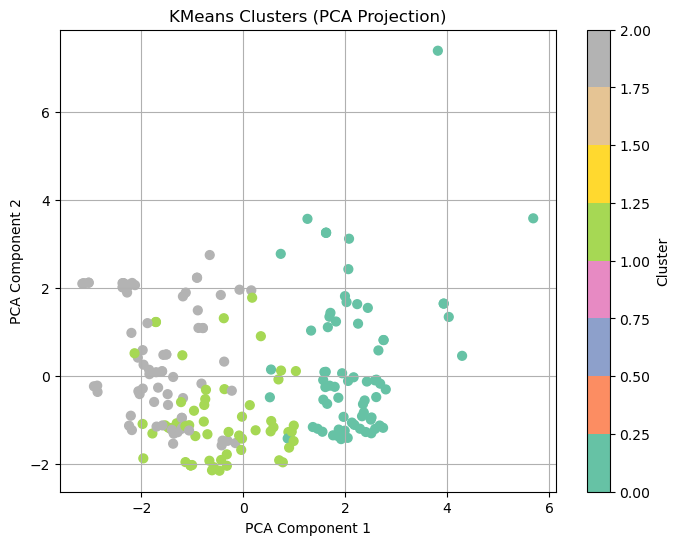

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled.drop(columns='kmeans_cluster'))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df_scaled['kmeans_cluster'], cmap='Set2', s=40)
plt.title('KMeans Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [26]:
# Copy the encoded DataFrame used for scaling
df_cluster_with_labels = df_cluster_encoded.copy()

# Add the cluster labels from KMeans
df_cluster_with_labels['cluster'] = kmeans_labels

# Summarize average values of features per cluster
cluster_summary = df_cluster_with_labels.groupby('cluster').mean().round(2)
cluster_summary

,fires_7day,acres_7day,max_frp,is_weekend,is_high_severity,is_long_duration,has_active_fire,is_high_fire_activity,season_Spring,season_Summer,season_Winter,CAUSE.CATEGORY_fuel supply emergency,CAUSE.CATEGORY_intentional attack,CAUSE.CATEGORY_islanding,CAUSE.CATEGORY_public appeal,CAUSE.CATEGORY_severe weather,CAUSE.CATEGORY_system operability disruption
cluster,,,,,,,,,,,,,,,,,
0,306.11,81343.61,1072.13,0.19,0.23,0.26,1.00,0.96,0.00,0.82,0.00,0.11,0.12,0.16,0.05,0.30,0.12
1,112.69,2687.73,170.04,0.17,0.31,0.22,0.93,0.33,0.83,0.00,0.00,0.05,0.17,0.05,0.07,0.19,0.38
2,51.52,1179.50,115.05,0.20,0.52,0.59,0.84,0.08,0.00,0.00,0.75,0.08,0.06,0.16,0.01,0.47,0.13


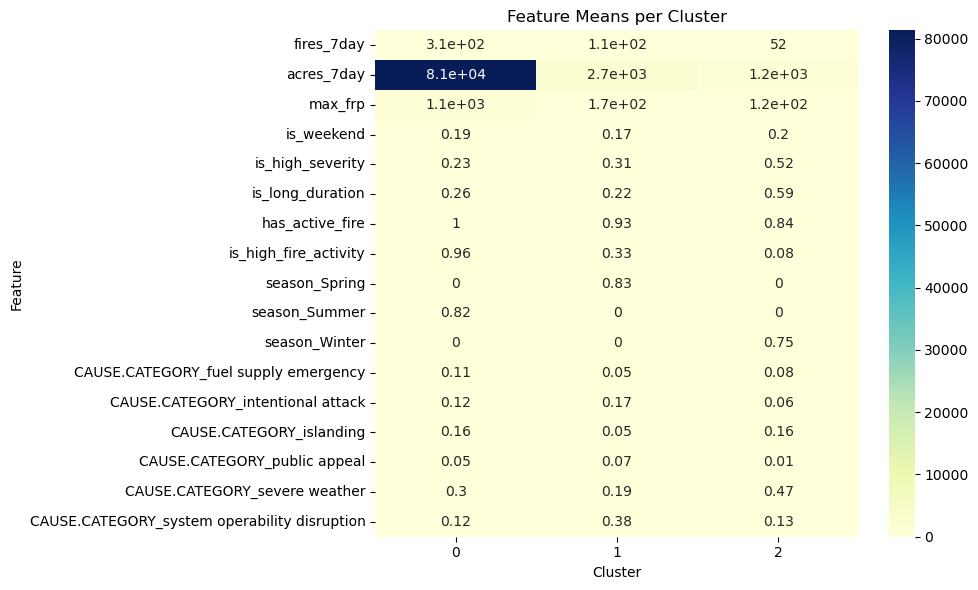

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary.T, annot=True, cmap="YlGnBu")
plt.title("Feature Means per Cluster")
plt.ylabel("Feature")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

In [31]:
# Create binary target: Major outage if more than 50,000 customers affected
df_class = df.copy()
df_class['is_major_outage'] = df_class['CUSTOMERS.AFFECTED'].astype(float) > 50000

# Drop target leakage and prepare features
X = df_class.drop(columns=['is_major_outage', 'CUSTOMERS.AFFECTED'])  # drop leakage
y = df_class['is_major_outage']

In [34]:
# One-hot encode any remaining categorical features
X_cleaned_encoded = pd.get_dummies(X_cleaned, drop_first=True)

# Now scale the encoded data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned_encoded)

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: One-hot encode any remaining categorical features
X_cleaned_encoded = pd.get_dummies(X_cleaned, drop_first=True)

# Step 2: Drop rows with missing values in features
X_cleaned_encoded = X_cleaned_encoded.dropna()

# Step 3: Keep only aligned targets (in case rows were dropped)
y = y.loc[X_cleaned_encoded.index]

# Step 4: Scale the encoded data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned_encoded)

# Step 5: Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 7: Make predictions
y_pred = rf.predict(X_test)

# Step 8: Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.967741935483871

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.95      0.97        19
        True       0.92      1.00      0.96        12

    accuracy                           0.97        31
   macro avg       0.96      0.97      0.97        31
weighted avg       0.97      0.97      0.97        31


Confusion Matrix:
 [[18  1]
 [ 0 12]]


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# ----- STEP 1: Target variable -----
df_reg = df.copy()
df_reg = df_reg[df_reg['OUTAGE.DURATION'].notna()]       # keep valid durations
df_reg['log_duration'] = np.log1p(df_reg['OUTAGE.DURATION'])

# ----- STEP 2: Align features -----
X_reg = X_encoded.loc[df_reg.index].copy()
y_reg = df_reg['log_duration']

# ----- STEP 3: REMOVE ALL DATE/TEXT COLUMNS -----
# Find all non-numeric columns (strings, dates)
non_numeric_cols = X_reg.select_dtypes(include=['object']).columns.tolist()

# EXTRA SAFETY: manually drop known date/time columns if present
date_cols = [col for col in X_reg.columns if 'date' in col.lower() or 'time' in col.lower()]
non_numeric_cols = list(set(non_numeric_cols + date_cols))

# Drop them
if len(non_numeric_cols) > 0:
    X_reg = X_reg.drop(columns=non_numeric_cols)

# ----- STEP 4: DROP ANY REMAINING NaNs -----
nan_mask = X_reg.isna().any(axis=1)
X_reg = X_reg[~nan_mask]
y_reg = y_reg[~nan_mask]

# ----- STEP 5: Train-test split -----
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# ----- STEP 6: Train regression model -----
reg = LinearRegression()
reg.fit(X_train_r, y_train_r)

# ----- STEP 7: Predict + evaluate -----
y_pred_r = reg.predict(X_test_r)

mae = mean_absolute_error(y_test_r, y_pred_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
r2 = r2_score(y_test_r, y_pred_r)

print("Regression Results:")
print(f"  MAE:  {mae:.3f}")
print(f"  RMSE: {rmse:.3f}")
print(f"  R²:   {r2:.3f}")

Regression Results:
  MAE:  1.294
  RMSE: 1.932
  R²:   0.142
